# 量的データ用（For quantitaive data）
[Methods]  
- Clustering methods : Kmeans, GMM, FSSEM, FSS-Kmeans    
- Allocation methods : random, proportional allocation, post stratification, optimal allocation

-------------
### ライブラリのインポート＆その他の設定（Importing Libraries & Other Settings）

In [1]:
# 基本的なライブラリ
import numpy as np
import pandas as pd
from numpy.typing import NDArray
from scipy import stats

# Scikit-learn関連
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.utils.validation import check_X_y
from sklearn.metrics import silhouette_score
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

# 抽象基底クラス (ABC)
from abc import ABCMeta, abstractmethod

# タイピングのサポート
from typing import Optional

# シード設定
# from lightning.pytorch import seed_everything
# seed_everything(8)

# 可視化の設定
import matplotlib.pyplot as plt
import japanize_matplotlib
import itertools

plt.style.use("ggplot")

--------
### 実験設定

In [2]:
TARGET = "GMV"  # "GMV"か"BCR"
DATA = "part"  # "all" or "part"
DATA_SIZE = 200000  # データサイズ(訓練データとテストデータあわせて）
TEST_SIZE = 0.5  # テストデータの比率
THRESHOLD = 0.1  # 外れ値除外の閾値

RANDOM_STATE = 0  # 乱数シード

N_CLUSTERS = 10
K_MIN = 2
K_MAX = 10

-----------
### データの前処理（Data Preprocessing）

In [3]:
# df1(all the data)
df1 = pd.read_csv(
    R"C:\Users\HaruMomozu\Documents\aug_first_cpn_data_for_ab_test_sensibility_tsukuba.csv"
)

features_list = [
    "hist_4_day_buy_num",
    "hist_4_day_gmv",
    "his_4_day_is_buy",
    "hist_30_day_buy_days",
    "hist_30_day_buy_num",
    "hist_30_day_gmv",
    "hist_30_day_buy_recency",
    "hist_30_day_pay_days",
    "hist_30_day_atpu",
    "hist_30_day_gpv",
    "hist_30_day_pay_recency",
    "hist_30_day_list_days",
    "hist_30_day_list_num",
    "hist_30_day_list_recency",
    "hist_30_day_like_count",
    "hist_30_day_like_count_not_deleted",
    "hist_30_day_like_recency",
]

# df2(subset of the data)
df2 = df1.iloc[:DATA_SIZE]

if DATA == "all":
    df = df1
if DATA == "part":
    df = df2

ALL_FEATURES_INDEX = [i for i in range(len(features_list))]
print(ALL_FEATURES_INDEX)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


In [4]:
df = df.copy()
df["BCR"] = np.where(df["GMV"] > 0, 1, 0)


In [5]:
# 外れ値の除去
def remove_outliers_zscore(
    data: pd.DataFrame, metric: str, threshold: float = 2
) -> pd.DataFrame:
    z_scores = np.abs(stats.zscore(data[metric]))
    data = data[(z_scores < threshold)]
    return data

In [6]:
df = remove_outliers_zscore(data=df, metric=TARGET, threshold=THRESHOLD)
df = df.reset_index(drop=True)  # 行を詰める

print("外れ値除外前のデータ数（訓練+テスト）:", DATA_SIZE)
print("外れ値除外後のデータ数（訓練+テスト）:", len(df))


外れ値除外前のデータ数（訓練+テスト）: 200000
外れ値除外後のデータ数（訓練+テスト）: 39595


In [7]:
X_all = df[features_list].to_numpy()
y_all = df[TARGET].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

print("訓練データのデータ数:", len(X_train))
print("テストデータのデータ数:", len(X_test))


訓練データのデータ数: 19797
テストデータのデータ数: 19798


In [8]:
sc = StandardScaler()
# 訓練データに基づいてfit
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)


-------------
### Kmeansのクラスタ数確認

In [10]:
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_STATE)
labels = kmeans.fit_predict(X_test_std)
cluster_size = np.bincount(labels)

print(cluster_size)


[7003 1111 2054  144  661   66    1 2044 5763  951]


-------------
### Xmeans で確認

##### Xmeans

In [8]:
def compute_bic(X, kmeans):
    labels = kmeans.labels_
    clusters = kmeans.cluster_centers_
    n_clusters = len(clusters)
    n = len(X)
    m = X.shape[1]
    variance = np.sum(
        [
            np.linalg.norm(X[labels == i] - clusters[i], axis=1).sum()
            for i in range(n_clusters)
        ]
    )
    bic = np.log(n) * n_clusters * m + n * np.log(variance / n)
    return bic


def xmeans(X, k_min=2, k_max=10):
    kmeans = KMeans(n_clusters=k_min, random_state=RANDOM_STATE)
    kmeans.fit(X)
    best_bic = compute_bic(X, kmeans)
    best_k = k_min
    score_dict = {}
    score_dict[k_min] = best_bic
    for k in range(k_min + 1, k_max + 1):
        kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
        kmeans.fit(X)
        current_bic = compute_bic(X, kmeans)
        score_dict[k] = current_bic
        if current_bic < best_bic:
            best_bic = current_bic
            best_k = k
    return best_k, score_dict

##### クラスタリング結果

In [ ]:
best_k, score_dict = xmeans(X_train_std, k_min=K_MIN, k_max=K_MAX)
print("n_clusters chosen in Xmeans:", best_k)

x = []
for k in score_dict.keys():
    x.append(str(k))
y = [score for score in score_dict.values()]
bars = plt.bar(x, y)
plt.ylabel("BIC", fontsize=30)
plt.xlabel("Number of clusters", fontsize=30)
plt.tick_params(axis="both", which="major", labelsize=25)
plt.tight_layout()
plt.show()

NameError: name 'X_scaled' is not defined

-----------------------------
### シルエット係数で確認

In [8]:
def silhouette(X, k_min=2, k_max=10):
    kmeans = KMeans(n_clusters=k_min, random_state=RANDOM_STATE)
    kmeans.fit(X)
    labels = kmeans.predict(X)
    best_score = silhouette_score(X, labels)
    score_dict = {}
    score_dict[k_min] = best_score
    best_k = k_min
    for k in range(k_min + 1, k_max + 1):
        kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
        kmeans.fit(X)
        labels = kmeans.predict(X)
        current_score = silhouette_score(X, labels)
        score_dict[k] = current_score
        if current_score > best_score:
            best_score = current_score
            best_k = k
    return best_k, score_dict

##### 結果

n_clusters chosen in Xmeans: 2


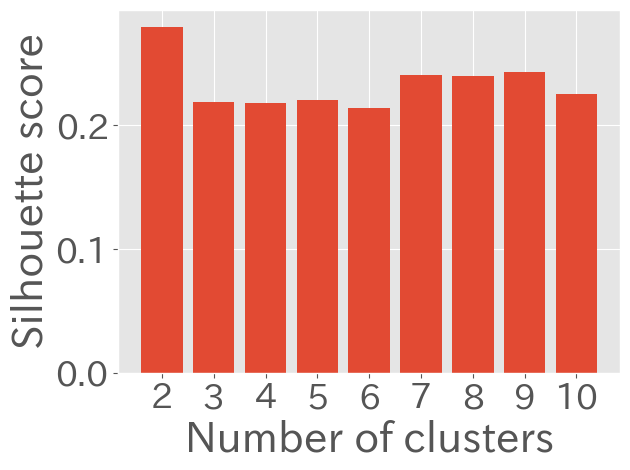

In [ ]:
best_k, score_dict = silhouette(X_train_std, k_min=K_MIN, k_max=K_MAX)
print("n_clusters chosen in Xmeans:", best_k)

x = []
for k in score_dict.keys():
    x.append(str(k))
y = [score for score in score_dict.values()]
bars = plt.bar(x, y)
plt.ylabel("Silhouette score", fontsize=30)
plt.xlabel("Number of clusters", fontsize=30)
plt.tick_params(axis="both", which="major", labelsize=25)
plt.tight_layout()
plt.show()

In [10]:
print(score_dict)

{2: 0.2792517590872323, 3: 0.2188797091200716, 4: 0.21799183344841971, 5: 0.22032629012328978, 6: 0.21431697766237381, 7: 0.24073160505271374, 8: 0.24025403663770717, 9: 0.24299605849082562, 10: 0.22507601320477036}
